# US-Umb Parameter perturbation
 * Michigan broadleaf deciduous forest
 * 10 years, 2001-2010
 * Satellite phenology
 * 300 ensemble members, varying 8 params
     * parameters are varying in all at once (latin hypercube)

In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Go get dask workers

In [2]:
#for use on Casper
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=12,
                     processes=12, memory="300GB",
                     project='P93300041',
                     walltime='2:00:00')
cluster.scale(12)
client = Client(cluster)

In [2]:
#for use on cheyenne
from dask_jobqueue import PBSCluster
from dask.distributed import Client
cluster = PBSCluster(cores=18,
                     processes=18, memory="50GB",
                     project='P93300041',
                     queue='regular',
                     resource_spec='select=1:ncpus=18:mem=109G',
                     walltime='01:00:00')
cluster.scale(18)
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.10.17:41733,Cluster Workers: 18 Cores: 18 Memory: 50.04 GB


### Read in data

In [5]:
# some output information
thedir = '/glade/scratch/djk2120/UMBens2/'
f = 'US-UMB_GPPcap_LHC0100.clm2.h1.2005-01-01-00000.nc'
paths = sorted(glob.glob(thedir+'*.h1.*'))
ens = 1+np.arange(300)
ixpft = 7

In [6]:
# grab model output
%time ds = xr.open_mfdataset(paths,concat_dim='ens',parallel='True')
ds['ens']=ens

CPU times: user 20.3 s, sys: 1.6 s, total: 21.9 s
Wall time: 25.4 s


In [7]:
ds.nbytes/1e9

3.997714136

In [8]:
# set up parameter reads
paramlist = ['theta_ip',
    'theta_cj',
    'fnps',
    'jmaxb0',
    'jmaxb1',
    'wc2wjb0',
    'xl',
    'theta_psii']

def parampath(ee):
    thedir = '/glade/scratch/djk2120/UMBens2/'
    pref = 'US-UMB_GPPcap_LHC'
    suff = '.nc'
    return thedir+pref+str(ee).zfill(4)+suff

def get_params(paramlist,ee,ixpft):
    thepath = parampath(ee)
    ps = xr.open_dataset(thepath)
    x = {}
    if ee==1:
        print(str(ps['pftname'][ixpft].values)[2:].split(' ')[0])
    for p in paramlist:
        if p in ps.data_vars:
            pshape = ps[p].values.shape
            dims = len(pshape)
            if dims==0:
                x[p] = ps[p].values
            elif (dims==1)&(pshape[0]==1):
                x[p] = ps[p].values
            elif (dims==1):
                x[p] = ps[p][ixpft].values
            else:
                #kmax,ck,psi50,rootprof_beta
                #does not handle segment variation
                x[p] = ps[p][0,:].values 
    return x

In [9]:
# read in the parameter values
from joblib import Parallel, delayed
import joblib
with joblib.parallel_backend('dask'):
    %time param_output = Parallel()(delayed(get_params)(paramlist,ee,ixpft) for ee in ens)

CPU times: user 4.71 s, sys: 386 ms, total: 5.1 s
Wall time: 5.41 s


In [10]:
# insert the parameter values into the dataset
nldir = '/glade/scratch/djk2120/UMBens2/'
for p in paramlist:
    if p in param_output[0]:
        x = np.array([param_output[i][p] for i in range(ens.size)])
    else:
        x = xr.open_dataset(nldir+p+'.nc')[p].values
    ds[p]=xr.DataArray(x,dims='ens')

In [11]:
# grab forcing data
forcing = ['RAIN','SNOW','FSDS','FSDSVD','FSDSVI','RH']
basecase = ('/glade/scratch/djk2120/drdfclm50d89wspinsp_US-UMB_I1PtClm50SpRsGs/run/'+
            'drdfclm50d89wspinsp_US-UMB_I1PtClm50SpRsGs.clm2.h1.2005-01-01-00000.nc')
b = xr.open_dataset(basecase)
for v in forcing:
    ds[v]=b[v]

In [12]:
ds

<xarray.Dataset>
Dimensions:         (ens: 300, hist_interval: 2, levdcmp: 1, levgrnd: 25, levlak: 10, lndgrid: 1, nvegwcs: 4, time: 87649)
Coordinates:
  * ens             (ens) int64 1 2 3 4 5 6 7 8 ... 294 295 296 297 298 299 300
  * levgrnd         (levgrnd) float32 0.01 0.04 0.09 ... 28.870724 41.998436
  * levlak          (levlak) float32 0.05 0.6 2.1 4.6 ... 25.6 34.325 44.775
  * levdcmp         (levdcmp) float32 1.0
  * time            (time) datetime64[ns] 2005-01-01 ... 2015-01-01
Dimensions without coordinates: hist_interval, lndgrid, nvegwcs
Data variables:
    mcdate          (ens, time) int32 dask.array<shape=(300, 87649), chunksize=(1, 87649)>
    mcsec           (ens, time) int32 dask.array<shape=(300, 87649), chunksize=(1, 87649)>
    mdcur           (ens, time) int32 dask.array<shape=(300, 87649), chunksize=(1, 87649)>
    mscur           (ens, time) int32 dask.array<shape=(300, 87649), chunksize=(1, 87649)>
    nstep           (ens, time) int32 dask.array<shape=(300

### Some data analysis

In [21]:
%time x = ds['FPSN'].groupby('ens').mean().load()

/glade/u/apps/ch/opt/python/3.6.8/gnu/8.3.0/pkg-library/20190627/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


CPU times: user 3.81 s, sys: 251 ms, total: 4.06 s
Wall time: 4.23 s


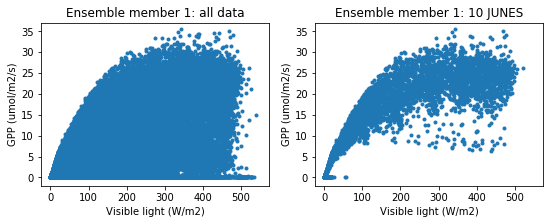

In [13]:
x = ds['FSDSVI']+ds['FSDSVD']
y = ds['FPSN'].sel(ens=1)

ix = ds['time.month']==6

plt.figure(figsize=[9,3])
plt.subplot(121)
plt.plot(x,y,'.')
plt.xlim([-25,575])
plt.ylim([-2,37])
plt.xlabel('Visible light (W/m2)')
plt.ylabel('GPP (umol/m2/s)')
plt.title('Ensemble member 1: all data')
plt.subplot(122)
plt.plot(x[ix],y[ix],'.')
plt.xlabel('Visible light (W/m2)')
plt.ylabel('GPP (umol/m2/s)')
plt.ylim([-2,37])
plt.xlim([-25,575])
plt.title('Ensemble member 1: 10 JUNES');


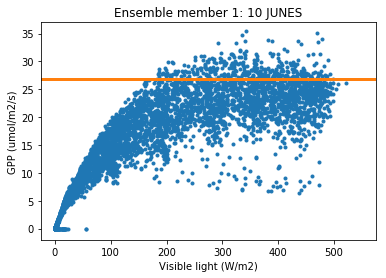

In [14]:
x = ds['FSDSVI']+ds['FSDSVD']
ix1 = (x.values>300).ravel()
ix2 = ds['time.month']==6
ix = np.logical_and(ix1,ix2)
out = np.zeros(300)
cap = np.quantile(ds['FPSN'].sel(ens=1)[ix],0.95)
plt.plot(x[ix],y[ix],'.')
plt.plot([-100,700],[cap,cap],linewidth=3)
plt.xlabel('Visible light (W/m2)')
plt.ylabel('GPP (umol/m2/s)')
plt.ylim([-2,37])
plt.xlim([-25,575])
plt.title('Ensemble member 1: 10 JUNES');

In [26]:
caps = [np.quantile(ds['FPSN'].sel(ens=ee)[ix],0.95) for ee in ens]
print('min='+str(np.round(np.min(caps),2)))
print('max='+str(np.round(np.max(caps),2)))

min=10.47
max=36.39


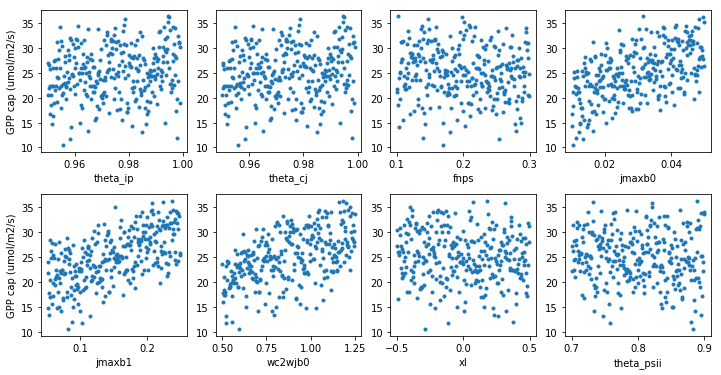

In [19]:
plt.figure(figsize=[12,6])
i = 0
for p in paramlist:
    i += 1
    plt.subplot(2,4,i)
    plt.plot(ds[p],caps,'.')
    plt.xlabel(p)
    if (i==1)|(i==5):
        plt.ylabel('GPP cap (umol/m2/s)')
plt.subplots_adjust(hspace=0.3)